# Example of using GCM for fitting a linear SCM (Structured Causal Models), retrieving the coefficients and bootstrapping for p-values
# This is a (simplified) derivative of my paper "A weighted false discovery rate adjusted p-values in aid of co-designing a causality graph with subject matter experts "
### Eli Y. Kling {https://www.linkedin.com/in/elikling/}
#
## The flow of this notebook;
- define a synthetic toy dataset
- Show the Simpson paradox it manifests (well all intros to Causality touch on this ;-) )
- Show how to define a simple liner SCM using the GCM capabilities
- Define a bootstrapping wrapper that returns the coefficients, covariances and appropriate p-values (that will be FDR corrected)
- Devised visualisations of the results
#
### Note: there is a discussion to be had on the right way to define the family of hypotheses which multiplicity needs to be controlled and on the suggested approach of comparing the covariance matrix induced by the SCM to the observed. See my paper once I get it published ;-)
#
#
## 15 June 2022 - Creation
## 24 June 2022 - Correlations p-values
## 12 July 2022 - bootstrap the p-values for the coefficients and the compare induced correlation matrices to expected
## 02 Aug  2022 - Clean up code & simplify output plotting
## 08 Aug  2022 - turn the bootstrap into function

In [1]:
# Libraries used in this notebook

# No-brainers
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.precision',4)
pd.options.display.max_rows = 20

import random
import copy
from scipy.stats import ttest_1samp # for t-test in the bootstap loop

# visulisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## Standerdized plotiing
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.figure(figsize=(5, 5))
sns.set_style('white')
AvaOrangeLight = "#FF5800"
AvaOrangeDark  = "#DC4600"
AvaGoldLight = "#FFB414"
AvaGoldDark  = "#E6A61C"


# For baseline comparisons
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # need this also for the SCM
import statsmodels.api as sm

# DoWhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy import gcm
from dowhy.gcm import refute_causal_structure
import networkx as nx # required for defining the SCM in gcm & could be used also for plotting
gcm.config.disable_progress_bars() # we will be running loads of gcm.fit during the bootstap

<Figure size 500x500 with 0 Axes>

Visualisation Legend


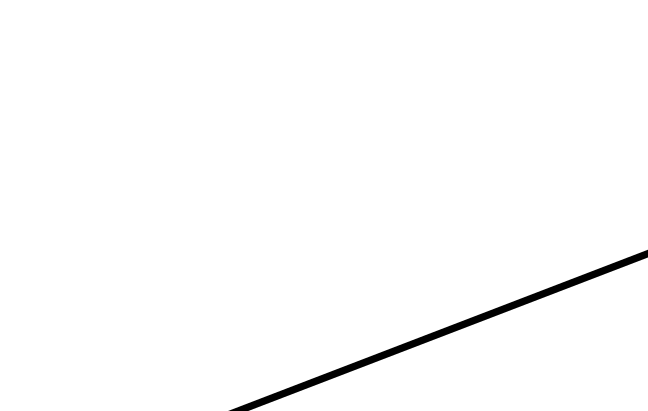

In [2]:
#Import utility functions I wrote
from false_discovery_rate_control import adjusted_FDR_pvalues
print("Visualisation Legend")
print("====================")
import scm_plots # this will display the ledgand for the visualisations
from scm_plots import scm_results_plot
from scm_plots import scm_induced_covariances_plot

# 1. Simpson's Paradox
- Create toy data where the paradox is evident
- Fit a naïve regression where the relation is not intuitive
- Then show what happens when a confounder is added (direction is changed)
- Throwing all the variables in kind of works but specifying a causal DAG will get the estimates correctly

In [3]:
# Toy data
# A depo manager needs to decide how much to refule the van
np.random.seed(seed=853210)

n_samples = 2000

Winter_Ind            = np.random.binomial(n=1                                  , p=0.24                      , size=n_samples)
Rain_Ind              = np.random.binomial(n=1                                  , p=(0.2 + Winter_Ind*0.3)    , size=n_samples)
Speed_KMpH            = np.random.normal  (loc=60 - Rain_Ind*0.9                , scale = 0.7                 , size=n_samples)
Fuel_Consumption_LpKM = np.random.normal  (loc=50 + Speed_KMpH/4 + Rain_Ind*2.1 , scale = 0.5                 , size=n_samples)

toy_example = pd.DataFrame(data=dict(Winter_Ind=Winter_Ind, Rain_Ind=Rain_Ind, Speed_KMpH=Speed_KMpH, Fuel_Consumption_LpKM=Fuel_Consumption_LpKM))
toy_example.head()

,Winter_Ind,Rain_Ind,Speed_KMpH,Fuel_Consumption_LpKM
0,0,0,59.9425,66.2462
1,1,1,59.7570,67.0014
2,0,0,59.9708,64.9859
3,0,0,60.5837,65.6836
4,0,0,60.0492,64.5607


In [4]:
df = copy.copy(toy_example)
df = df.reset_index(drop=True) # just to be on the safe side

#the automodel identifiyes categorical variables if they are corretly typed and we need this in anycase for corretly modeling 0 & 1
df.Winter_Ind = df.Winter_Ind.astype("category")
df["Rain_Ind_Cat"] =df["Rain_Ind"].apply(str)

### Naïve approach would be to either model the consumption as a function of speed or try to chuck everithing in

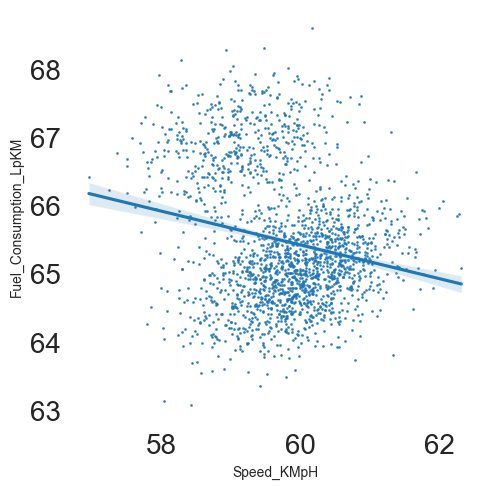

In [5]:
# In this approach the fuel consuption declines as speed increases.
g = sns.lmplot(x="Speed_KMpH", y="Fuel_Consumption_LpKM", data=df, scatter_kws={"s": 1})
sns.despine(bottom = True, left = True)

In [6]:
#Super naïve: model Fuel = f(Speed)
X=np.array(df.Speed_KMpH).reshape((-1, 1))
Y=np.array(df.Fuel_Consumption_LpKM)
X2 = sm.add_constant(X)
ols1 = sm.OLS(Y, X2)
ols1Fit = ols1.fit()
print(ols1Fit.summary())
print(":")
print("Note: very poor fit statistics although the coeficiants are (kind of) statistically significant")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     85.63
Date:                Wed, 26 Mar 2025   Prob (F-statistic):           5.40e-20
Time:                        21:39:12   Log-Likelihood:                -2762.4
No. Observations:                2000   AIC:                             5529.
Df Residuals:                    1998   BIC:                             5540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.2922      1.601     50.155      0.0

In [7]:
# Brute-force model Fuel = f(all vars)
X=np.array(df[["Speed_KMpH","Winter_Ind","Rain_Ind"]]).reshape((-1, 3))
Y=np.array(df.Fuel_Consumption_LpKM)
X2 = sm.add_constant(X)
ols2 = sm.OLS(Y, X2)
ols2Fit = ols2.fit()
print(ols2Fit.summary())
print(":")
print("Note: this looks better - fit is improved and the coeficinet are kind of in the right ball park. ")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1788.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:39:12   Log-Likelihood:                -1499.4
No. Observations:                2000   AIC:                             3007.
Df Residuals:                    1996   BIC:                             3029.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7105      0.967     49.315      0.0

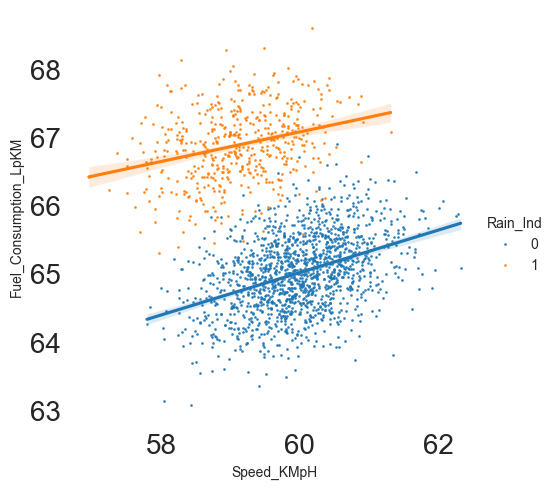

In [8]:
#Let's plot this
g = sns.lmplot(x="Speed_KMpH", y="Fuel_Consumption_LpKM", hue="Rain_Ind", data=df, scatter_kws={"s": 1})
sns.despine(bottom = True, left = True)

# 2. Fit a postulated DAG with DoWhy GSM
#
### Talk to a subject mater expert (SME) and construct a causality graph that also takes into account the correlation between rain and winter
#
#### Yeh, the expert will think that people drive slower in winter - well my dad thinks so ;-)

In [9]:
# First look at the correlations then used experiance and experties to define a causality DAG
temp = copy.copy(df)
temp.Winter_Ind = temp.Winter_Ind.astype("int64") # did I say yet I miss SAS? It was so much better at this than R or Python.
temp.cov()

,Winter_Ind,Rain_Ind,Speed_KMpH,Fuel_Consumption_LpKM,Rain_Ind_Cat
Winter_Ind,0.1772,0.0491,-0.0505,0.0922,0.0491
Rain_Ind,0.0491,0.1886,-0.1633,0.3536,0.1886
Speed_KMpH,-0.0505,-0.1633,0.6471,-0.1604,-0.1633
Fuel_Consumption_LpKM,0.0922,0.3536,-0.1604,0.9675,0.3536
Rain_Ind_Cat,0.0491,0.1886,-0.1633,0.3536,0.1886


In [10]:
nxDAG = nx.DiGraph([('Winter_Ind'  , 'Rain_Ind_Cat'),
                    ('Winter_Ind'  , 'Speed_KMpH'),
                    ('Rain_Ind_Cat', 'Speed_KMpH'),
                    ('Speed_KMpH'  , 'Fuel_Consumption_LpKM')])

scm = gcm.StructuralCausalModel(nxDAG) 

scm.set_causal_mechanism('Winter_Ind'           , gcm.EmpiricalDistribution())
scm.set_causal_mechanism('Rain_Ind_Cat'         , gcm.ClassifierFCM(gcm.ml.create_logistic_regression_classifier()))
# As Rain_ind_Cat is hot encoded automatically there is no need for an intercept. the effect of rain will be beta(rain=1) - beta(rain=0)
scm.set_causal_mechanism('Speed_KMpH'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor(fit_intercept=False)))
scm.set_causal_mechanism('Fuel_Consumption_LpKM', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

# Just for reference you could auto descide the functional fit using the line bellow
# gcm.auto.assign_causal_mechanisms(scm,df) - this will use gradiant bootsing for cont variables

gcm.fit(scm, df)

In [11]:
# Get the coefficiants
print("--- Rain_Ind: Rememebr this is a logistic regression - the coeficnets need to be converted to probality terminology ---")
print(scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.coef_)
print("--- Speed_KMpH ---")
print(scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_)
print("--- Fuel_Consumption_LpKM ---")
print(scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_)

--- Rain_Ind: Rememebr this is a logistic regression - the coeficnets need to be converted to probality terminology ---
[-1.4557795]
[[1.30570757]]
--- Speed_KMpH ---
0.0
[ 5.99831629e+01  5.91301899e+01 -4.87588011e-02]
--- Fuel_Consumption_LpKM ---
80.29224193219069
[-0.24788584]


# 3. Bootstrap the p-values for the coefficients and the compare induced correlation matrices to expected
## Bootstrap loop;
### sample from the data
### correlation matrix
### fit model
### get coefficients
### get induced correlation matrix from drawn samples
### apply FDR adjustment to the p-values

In [12]:
# Convert Logistic ods ratios to probaility terminolagy
def logit2prob (logit):
    odds = np.exp(logit)
    prob = odds / (1 + odds)
    return(prob)
print(logit2prob(0.74)) #should be 0.676996

0.676995856238523


In [13]:
def bootstrap_scms(n_boot, input_df, scm_parameters_func, scm_parameter_names):
    ''' This is written for the purpose of the example in this notebook. Much more work needs to be done to generalise it.
        The output DataFrame complies with the structure obtained while using sempoy and is used as input for the visualisation functions

        Param: n_boot - number of bootstap iterations
        Param: input_df - Pandas datafream with the varialbes that are hard coded bellow
        Param: scm_parameters_func - a function matched to the SCM mapping the coeficnets [retuns list with an expected order]
        Param: scm_parameter_names - ordered list labeling the output of scm_parameters_func
        
        Return: Pandas dataframe with parameter estimates, raw p-values and FDR adjusted p-values
        '''

    import statsmodels.stats.weightstats as ssws # for TOST

    origianl_df = copy.copy(input_df)
    df_nobs = origianl_df.shape[0]
    # df_ncols = origianl_df.shape[1] - as there is Rain_ind & Rain_ind_Cat we really need to only count the numeric fields
    # the order is important as the tranlge will be vectorised and the position has a meaning
    df_columns=origianl_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64','category']).columns.tolist()
    df_ncols=len(df_columns)

    #W hen looking at the covariance matrix we need only the upper triangle, including the diagonal. It is more efficiant to flatten it.
    n_covariaces = int(df_ncols * (df_ncols-1) / 2 + df_ncols)

    bootstapped_covariances_list = []
    SCM_covariances_list = []
    scm_parameters = []
    for ib in range(n_boot):
        # sample form the data - no need to apply null hypotheisis conditions (no correlations at all) as we want the mean and std of the coefficants and assume we know that the null distibution of noise is normal
        # one can use sample but stackoverflow suggests this approach is more efficiant
        random_pointers = pd.DataFrame(index=np.random.randint(df_nobs, size=df_nobs))
        bootstrap_df = origianl_df.merge(random_pointers, left_index=True, right_index=True, how='right')
        
        # fit the scm & get the parameters
        gcm.fit(scm, bootstrap_df)
        scm_parameters_bi = scm_parameters_func(scm)
        scm_parameters.append(scm_parameters_bi)

        # The covariae of the bootstapped sample
        bootstrap_df.Winter_Ind = bootstrap_df.Winter_Ind.astype("int64")
        # control the order of columns so not to loos the link to the index of the flattened covariance
        bootstrap_df = bootstrap_df[df_columns].reset_index(drop=True)
        
        #bootstrap_df_corr = bootstrap_df.corr()
        bootstrap_df_cov = bootstrap_df.cov().to_numpy()
    
        # Now sample from the scm, estimate the induced covariances and compare to the 'original' cov matrix
        scm_sample=gcm.draw_samples(scm,df_nobs)
        scm_sample.Winter_Ind = scm_sample.Winter_Ind.astype("int64")
        scm_sample["Rain_Ind"]   = scm_sample.Rain_Ind_Cat.astype("float")
        # control the order of columns so not to loos the link to the index of the flattened covariance
        scm_sample = scm_sample[df_columns].reset_index(drop=True)
        scm_induced_cov = scm_sample.cov().to_numpy()
        
        #Calculate the differnece measure to do the an equivalance (TOST) test H0(1): SCM_Induced_Cov-dataset_Cov < -d & H0(2): SCM_Induced_Cov-dataset_Cov > d
        #to do that the covariances for the bootstapped dataframe and the induced by the SCM are stored (flattning the upper triangle)
        bootstapped_cs = np.zeros((n_covariaces))
        SCM_cs = np.zeros((n_covariaces))
        cs_index = 0
        for i in range(df_ncols):
            for j in range(i,df_ncols):
                bootstapped_cs[cs_index] = bootstrap_df_cov[i,j]
                SCM_cs[cs_index] = scm_induced_cov[i,j]
                cs_index = cs_index + 1
        bootstapped_covariances_list.append(bootstapped_cs)
        SCM_covariances_list.append(SCM_cs)

        #deleteing the temp dataframe both to ensure not rubish is carried over and to clear memory
        lst = [random_pointers, bootstrap_df, scm_sample]
        del random_pointers
        del bootstrap_df
        del scm_sample
        del lst
        # End of for ib

    bootstapped_covariances = np.array(bootstapped_covariances_list)
    SCM_covariances         = np.array(SCM_covariances_list)

    delta = 0.10 #acceptance rand for TOST
    cs_index = 0
    cov_record_list = []
    for i in range(df_ncols):
        for j in range(i,df_ncols):
            x1=bootstapped_covariances[ : , cs_index]
            x2=SCM_covariances[ : , cs_index]
            
            TOST_pvalue = ssws.ttost_ind(x1 = x1, x2 = x2, low = -1 * delta, upp = delta, usevar='unequal')[0]
            # edge  Estimate p-value lval rval op
            cov_record_list.append(['covariance', (np.mean(x2)), TOST_pvalue, df_columns[i], df_columns[j], "~~"])
            cs_index = cs_index + 1

    cov_record_df=pd.DataFrame(cov_record_list)
    cov_record_df.columns = ['edge', 'Estimate', 'p-value', 'lval', 'rval', 'op']

    # regressions estimates
    scm_parameters_df = pd.DataFrame(scm_parameters)
    scm_parameters_df.columns = scm_parameter_names

    parameters_pvalues = pd.DataFrame(ttest_1samp(scm_parameters_df, 0).pvalue, columns = ['p-value'])

    #now that the p-values are calculated 'transalte' the logistic parameters == de-exponenet them
    scm_parameters_df['Rain_Ind~Winter_Ind'] = logit2prob((scm_parameters_df['Rain_Ind~Intercept'] + scm_parameters_df['Rain_Ind~Winter_Ind']))
    scm_parameters_df['Rain_Ind~Intercept'] = logit2prob(scm_parameters_df['Rain_Ind~Intercept'])


    parameter_sammary = pd.DataFrame(scm_parameters_df.mean()).reset_index()
    parameter_sammary.columns = ['edge', 'Estimate']

    parameter_sammary = pd.concat([parameter_sammary, parameters_pvalues],axis=1)
    parameter_sammary[['lval','rval']] =  parameter_sammary['edge'].str.split("~", expand=True)
    parameter_sammary['op']="~" # just so my code using semopy output works

    bootstrap_estimate = pd.concat([parameter_sammary, cov_record_df], axis = 0, ignore_index=True)
    bootstrap_estimate.reset_index(drop=True)

    #Multiplicity ocontrol
    bootstrap_estimate["raw_pvalue"] = bootstrap_estimate["p-value"]
    bootstrap_estimate["p-value"] = adjusted_FDR_pvalues(bootstrap_estimate["raw_pvalue"])
    return bootstrap_estimate
    #end def bootstrap_scms()

# 3.1 define a not so good DAG so you can see how this appraoch highlighs potencial improvments

In [14]:
nxDAG = nx.DiGraph([('Winter_Ind'  , 'Rain_Ind_Cat'),
                    ('Winter_Ind'  , 'Speed_KMpH'),
                    ('Rain_Ind_Cat', 'Speed_KMpH'),
                    ('Speed_KMpH'  , 'Fuel_Consumption_LpKM')])

scm = gcm.StructuralCausalModel(nxDAG) 

scm.set_causal_mechanism('Winter_Ind'           , gcm.EmpiricalDistribution())
# As Rain_ind_Cat is hot encoded automatically there is no need for an intercept. the effect of rain will be beta(rain=1) - beta(rain=0)
scm.set_causal_mechanism('Rain_Ind_Cat'         , gcm.ClassifierFCM(gcm.ml.create_logistic_regression_classifier()))
scm.set_causal_mechanism('Speed_KMpH'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor(fit_intercept=False)))
scm.set_causal_mechanism('Fuel_Consumption_LpKM', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(scm, df)

def scm_parameters(scm):
    return (
        scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.intercept_[0],
        scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.coef_[0][0],
        scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[0],
        (scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[1] - scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[0]),
        scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[2],
        scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_[0]
        )
display()
display("scm_parameters")
display (scm_parameters(scm))
display()
scm_parameter_names = ['Rain_Ind~Intercept',
                       'Rain_Ind~Winter_Ind',
                       'Speed_KMpH~Intercept',
                       'Speed_KMpH~Rain_Ind',
                       'Speed_KMpH~Winter_Ind',
                       'Fuel_Consumption_LpKM~Intercept',
                       'Fuel_Consumption_LpKM~Speed_KMpH']
bootstrap_estimate = bootstrap_scms(n_boot=2000, input_df = df, scm_parameters_func=scm_parameters, scm_parameter_names = scm_parameter_names)

'scm_parameters'

In [15]:
bootstrap_estimate

,edge,Estimate,p-value,lval,rval,op,raw_pvalue
0,Rain_Ind~Intercept,0.1894,0.0,Rain_Ind,Intercept,~,0.0
1,Rain_Ind~Winter_Ind,0.4633,0.0,Rain_Ind,Winter_Ind,~,0.0
2,Speed_KMpH~Intercept,59.9837,0.0,Speed_KMpH,Intercept,~,0.0
3,Speed_KMpH~Rain_Ind,-0.8533,0.0,Speed_KMpH,Rain_Ind,~,0.0
4,Speed_KMpH~Winter_Ind,-0.0492,0.0,Speed_KMpH,Winter_Ind,~,0.0
5,Fuel_Consumption_LpKM~Intercept,80.3249,0.0,Fuel_Consumption_LpKM,Intercept,~,0.0
6,Fuel_Consumption_LpKM~Speed_KMpH,-0.2484,0.0,Fuel_Consumption_LpKM,Speed_KMpH,~,0.0
7,covariance,0.1770,0.0,Winter_Ind,Winter_Ind,~~,0.0
8,covariance,0.0484,0.0,Winter_Ind,Rain_Ind,~~,0.0
9,covariance,-0.0499,0.0,Winter_Ind,Speed_KMpH,~~,0.0


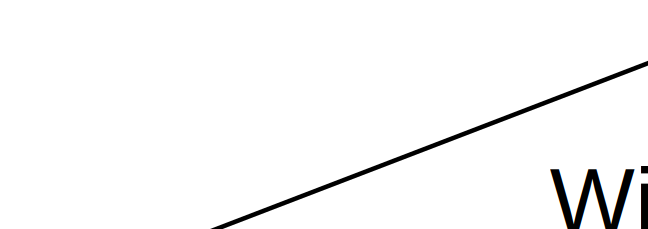

In [16]:
scm_results_plot(df.columns, bootstrap_estimate, 'figs/model_estimates_01')

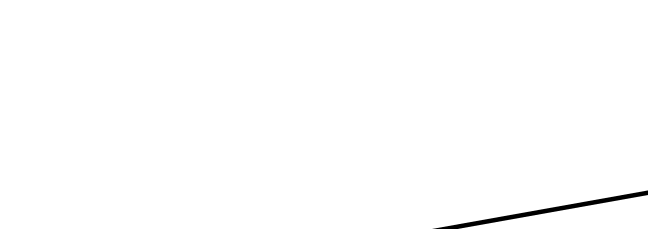

In [17]:
scm_induced_covariances_plot(df.columns, bootstrap_estimate, 'figs/scm_induced_covariances_01')

# 3.2 Second attempt:
##
## the SCM looked ok but did not really get the observed covariace matrix.
## remove Winter -> Speed (the estimate is low = 'practically insignificant')
## add Rain -> Fuel (maybe this will sort out the covariance? + The expert thinks there could be a causal link here)

In [18]:
nxDAG = nx.DiGraph([('Winter_Ind'   , 'Rain_Ind_Cat'),
                    ('Rain_Ind_Cat' , 'Speed_KMpH'),
                    ('Rain_Ind_Cat' , 'Fuel_Consumption_LpKM'),
                    ('Speed_KMpH'   , 'Fuel_Consumption_LpKM')])

scm = gcm.StructuralCausalModel(nxDAG) 

scm.set_causal_mechanism('Winter_Ind'           , gcm.EmpiricalDistribution())
# As Rain_ind_Cat is hot encoded automatically there is no need for an intercept. the effect of rain will be beta(rain=1) - beta(rain=0)
scm.set_causal_mechanism('Rain_Ind_Cat'         , gcm.ClassifierFCM(gcm.ml.create_logistic_regression_classifier()))
scm.set_causal_mechanism('Speed_KMpH'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor(fit_intercept=False)))
scm.set_causal_mechanism('Fuel_Consumption_LpKM', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor(fit_intercept=False)))

gcm.fit(scm, df)

def scm_parameters(scm):
    return (
            scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.intercept_[0],
            scm.causal_mechanism('Rain_Ind_Cat').classifier_model.sklearn_model.coef_[0][0],
            scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[0],
            (scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[1] - scm.causal_mechanism('Speed_KMpH').prediction_model.sklearn_model.coef_[0]),

            scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_[0],
            (scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_[1] - scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_[0]),
            scm.causal_mechanism('Fuel_Consumption_LpKM').prediction_model.sklearn_model.coef_[2]
            )
display()
display("scm_parameters")
display (scm_parameters(scm))
display()
scm_parameter_names = ['Rain_Ind~Intercept',
                       'Rain_Ind~Winter_Ind',
                       'Speed_KMpH~Intercept',
                       'Speed_KMpH~Rain_Ind',
                       'Fuel_Consumption_LpKM~Intercept',
                       'Fuel_Consumption_LpKM~Rain_Ind',
                       'Fuel_Consumption_LpKM~Speed_KMpH']
bootstrap_estimate = bootstrap_scms(n_boot=2000, input_df = df, scm_parameters_func=scm_parameters, scm_parameter_names = scm_parameter_names)

'scm_parameters'

In [19]:
bootstrap_estimate

,edge,Estimate,p-value,lval,rval,op,raw_pvalue
0,Rain_Ind~Intercept,0.1891,0.0,Rain_Ind,Intercept,~,0.0
1,Rain_Ind~Winter_Ind,0.4622,0.0,Rain_Ind,Winter_Ind,~,0.0
2,Speed_KMpH~Intercept,59.9750,0.0,Speed_KMpH,Intercept,~,0.0
3,Speed_KMpH~Rain_Ind,-0.8660,0.0,Speed_KMpH,Rain_Ind,~,0.0
4,Fuel_Consumption_LpKM~Intercept,47.7382,0.0,Fuel_Consumption_LpKM,Intercept,~,0.0
5,Fuel_Consumption_LpKM~Rain_Ind,2.1242,0.0,Fuel_Consumption_LpKM,Rain_Ind,~,0.0
6,Fuel_Consumption_LpKM~Speed_KMpH,0.2879,0.0,Fuel_Consumption_LpKM,Speed_KMpH,~,0.0
7,covariance,0.1767,0.0,Winter_Ind,Winter_Ind,~~,0.0
8,covariance,0.0483,0.0,Winter_Ind,Rain_Ind,~~,0.0
9,covariance,-0.0422,0.0,Winter_Ind,Speed_KMpH,~~,0.0


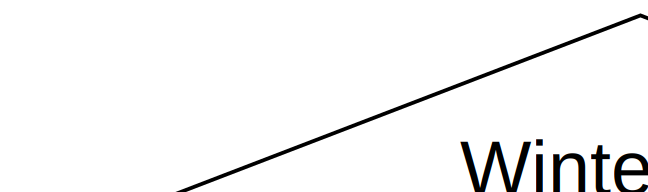

In [20]:
scm_results_plot(df.columns, bootstrap_estimate, 'figs/model_estimates_02')

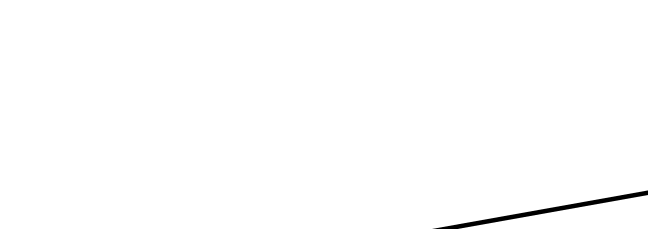

In [21]:
scm_induced_covariances_plot(df.columns, bootstrap_estimate, 'figs/scm_induced_covariances_02')